In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!git clone https://github.com/jasonfghx/Chest_X_Ray.git

Cloning into 'Chest_X_Ray'...
remote: Enumerating objects: 2575, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 2575 (delta 4), reused 0 (delta 0), pack-reused 2277 (from 1)
Receiving objects: 100% (2575/2575), 454.72 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Updating files: 100% (2357/2357), done.


In [2]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization ,Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



In [3]:
data_dir2 = '/content/Chest_X_Ray/train/'
data_dir = '/content/Chest_X_Ray/train/'


filepaths = []
labels = []

folds = os.listdir(data_dir)
# folds.remove('NORMAL')
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


folds = ['TURBERCULOSIS' , 'PNEUMONIA','NORMAL','COVID19']

for fold in folds:
    foldpath = os.path.join(data_dir2, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [5]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
  return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3499 validated image filenames belonging to 4 classes.
Found 525 validated image filenames belonging to 4 classes.
Found 350 validated image filenames belonging to 4 classes.


In [7]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
print(classes)

['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [8]:
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [9]:

# https://www.kaggle.com/code/krishnakumarkk/ensemble-nn-vgg16-resnet50-inceptionv3
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(224,224,3))
class_count = len(list(train_gen.class_indices.keys()))
for layers in vgg16_model.layers:
  layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(class_count, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
learning_rate=0.0001
optimizer = Adam(learning_rate=learning_rate)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])

# VGG16
number_of_epochs = 10


vgg16_history = vgg16_final_model.fit(train_gen, epochs = number_of_epochs ,validation_data =valid_gen ,verbose=1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - acc: 0.4590 - loss: 2.0141 - val_acc: 0.8419 - val_loss: 0.4923
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 99s 766ms/step - acc: 0.8451 - loss: 0.4143 - val_acc: 0.8857 - val_loss: 0.3101
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 721ms/step - acc: 0.9008 - loss: 0.2578 - val_acc: 0.9181 - val_loss: 0.2343
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 89s 835ms/step - acc: 0.9261 - loss: 0.1953 - val_acc: 0.9333 - val_loss: 0.1934
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 741ms/step - acc: 0.9464 - loss: 0.1446 - val_acc: 0.9352 - val_loss: 0.1624
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 736ms/step - acc: 0.9505 - loss: 0.1339 - val_acc: 0.9448 - val_loss: 0.1416
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 80s 728ms/step - acc: 0.9560 - loss: 0.1141 - val_acc: 0.9562 - val_loss: 0.1267
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 83s 749ms/step - acc: 0.9676 - loss: 0.0996 - val_acc: 0.9619 - val_loss: 0.1128


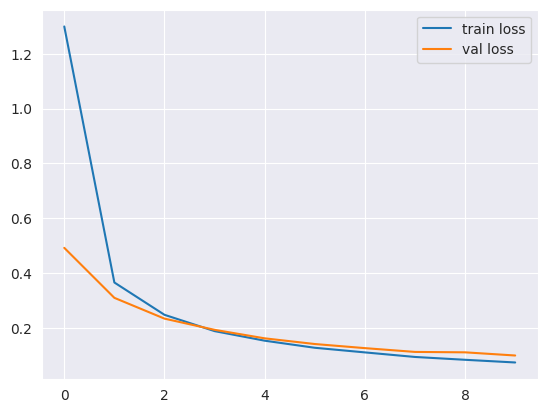

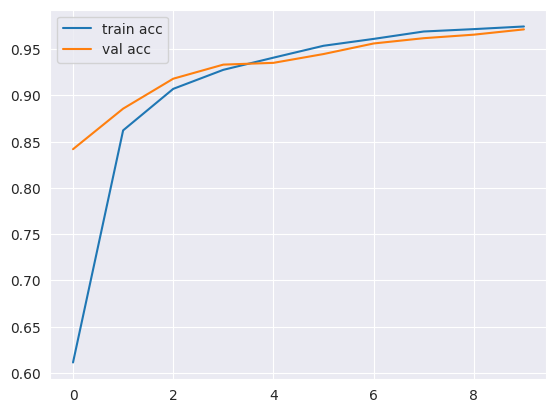

In [10]:

plt.plot(vgg16_history.history['loss'], label='train loss')
plt.plot(vgg16_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(vgg16_history.history['acc'], label='train acc')
plt.plot(vgg16_history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layers in model.layers:
  layers.trainable=False
last_output = model.layers[-1].output
EFF_x = Flatten()(last_output)
EFF_x = Dense(128, activation = 'relu')(EFF_x)
EFF_x = Dense(class_count, activation = 'softmax')(EFF_x)
EFF_final_model = Model(model.input, EFF_x)
EFF_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])


number_of_epochs = 10


EFF_history = EFF_final_model.fit(train_gen, epochs = number_of_epochs ,validation_data =valid_gen ,verbose=1)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - acc: 0.6506 - loss: 3.9052 - val_acc: 0.9597 - val_loss: 0.9898
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 471ms/step - acc: 0.9830 - loss: 0.3587 - val_acc: 0.9839 - val_loss: 0.8541
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 464ms/step - acc: 0.9978 - loss: 0.0136 - val_acc: 0.9839 - val_loss: 0.5875
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 555ms/step - acc: 0.9976 - loss: 0.0073 - val_acc: 0.9839 - val_loss: 0.6964
Epoch 5/10


In [ ]:

plt.plot(EFF_history.history['loss'], label='train loss')
plt.plot(EFF_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(EFF_history.history['acc'], label='train acc')
plt.plot(EFF_history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
number_of_epochs = 3
CNN_history = model.fit(train_gen, epochs = number_of_epochs ,validation_data =valid_gen ,verbose=1)

Epoch 1/3
55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 939ms/step - acc: 0.4474 - loss: 616.1513 - val_acc: 0.4895 - val_loss: 1.1713
Epoch 2/3
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 646ms/step - acc: 0.5817 - loss: 1.0101 - val_acc: 0.7067 - val_loss: 0.9329
Epoch 3/3
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 622ms/step - acc: 0.6631 - loss: 0.8821 - val_acc: 0.7867 - val_loss: 0.7957


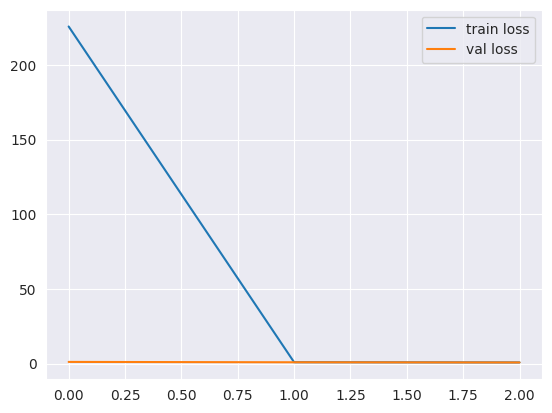

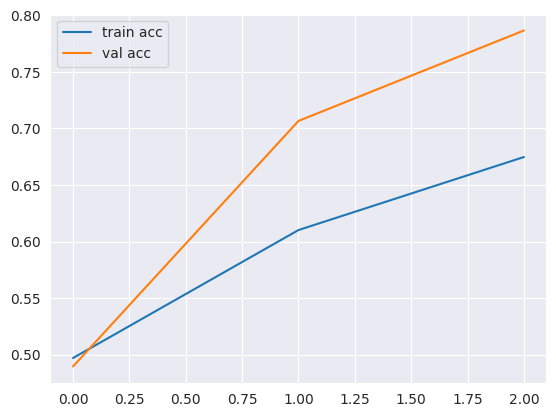

In [ ]:

plt.plot(CNN_history.history['loss'], label='train loss')
plt.plot(CNN_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.plot(CNN_history.history['acc'], label='train acc')
plt.plot(CNN_history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
# 測試用
data_dir2 = '/content/Chest_X_Ray/test/'
data_dir = '/content/Chest_X_Ray/test/'


filepaths = []
labels = []

folds = os.listdir(data_dir)
# folds.remove('NORMAL')
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)


folds = ['TURBERCULOSIS' , 'PNEUMONIA','NORMAL','COVID19']

for fold in folds:
    foldpath = os.path.join(data_dir2, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
test_gen = ts_gen.flow_from_dataframe( df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= 1)
temp=vgg16_final_model.predict(test_gen)

Found 340 validated image filenames belonging to 4 classes.
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step


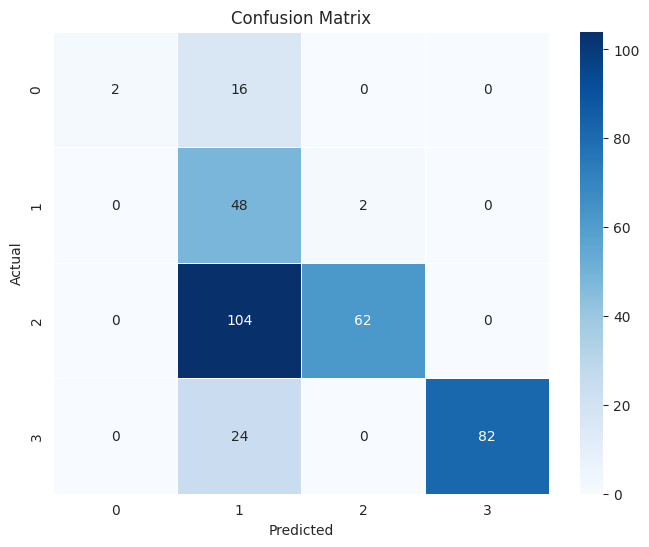

In [ ]:
from sklearn.metrics import confusion_matrix
dict1={'COVID19':0,'NORMAL':1,'PNEUMONIA':2,'TURBERCULOSIS':3}
df['labels1']=df['labels'].map(dict1)
GB_confusion = confusion_matrix(np.argmax(temp,axis=1), list(df['labels1']))
plt.figure(figsize=(8, 6))
sns.heatmap(GB_confusion, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
df['labels'].value_counts()

,count
labels,
NORMAL,192
TURBERCULOSIS,82
PNEUMONIA,64
COVID19,2
